# Sicily smoking ban analysis

In [51]:
# importing project libraries
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

import warnings
warnings.filterwarnings('ignore')


In [52]:
# reading the data set
df = pd.read_csv(r"data\sicily.csv")

In [53]:
# inspecting head
df.head()

,year,month,aces,time,smokban,pop,stdpop
0,2002,1,728,1,0,364277.4,379875.3
1,2002,2,659,2,0,364277.4,376495.5
2,2002,3,791,3,0,364277.4,377040.8
3,2002,4,734,4,0,364277.4,377116.4
4,2002,5,757,5,0,364277.4,377383.4


In [54]:
# inspecting info
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     59 non-null     int64  
 1   month    59 non-null     int64  
 2   aces     59 non-null     int64  
 3   time     59 non-null     int64  
 4   smokban  59 non-null     int64  
 5   pop      59 non-null     float64
 6   stdpop   59 non-null     float64
dtypes: float64(2), int64(5)
memory usage: 3.4 KB


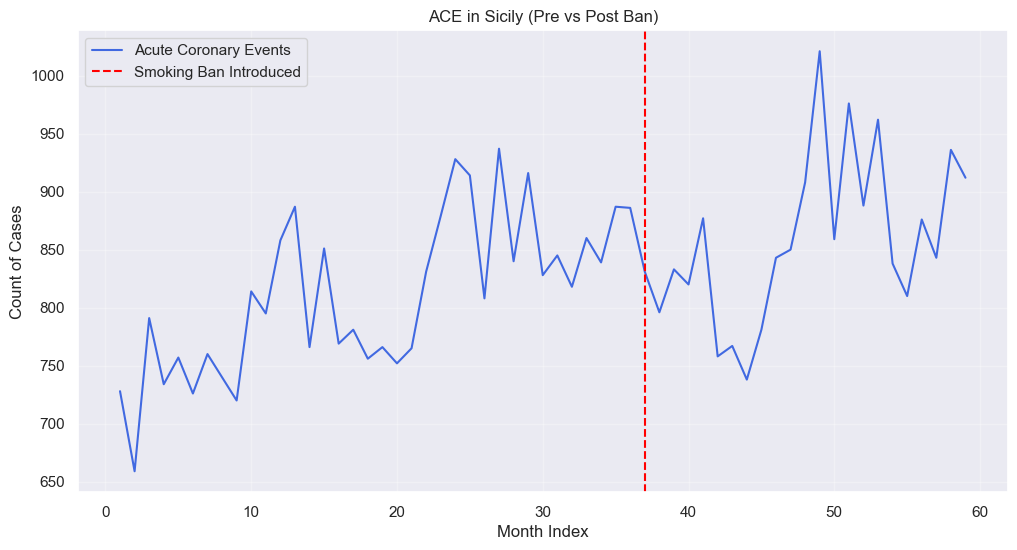

In [55]:
# visualize ACE over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='time', y='aces', color='royalblue', label='Acute Coronary Events')

# Find the start of the ban
ban_start_time = df[df['smokban'] == 1]['time'].min()
plt.axvline(x=ban_start_time, color='red', linestyle='--', label='Smoking Ban Introduced')

plt.title('ACE in Sicily (Pre vs Post Ban)')
plt.xlabel('Month Index')
plt.ylabel('Count of Cases')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

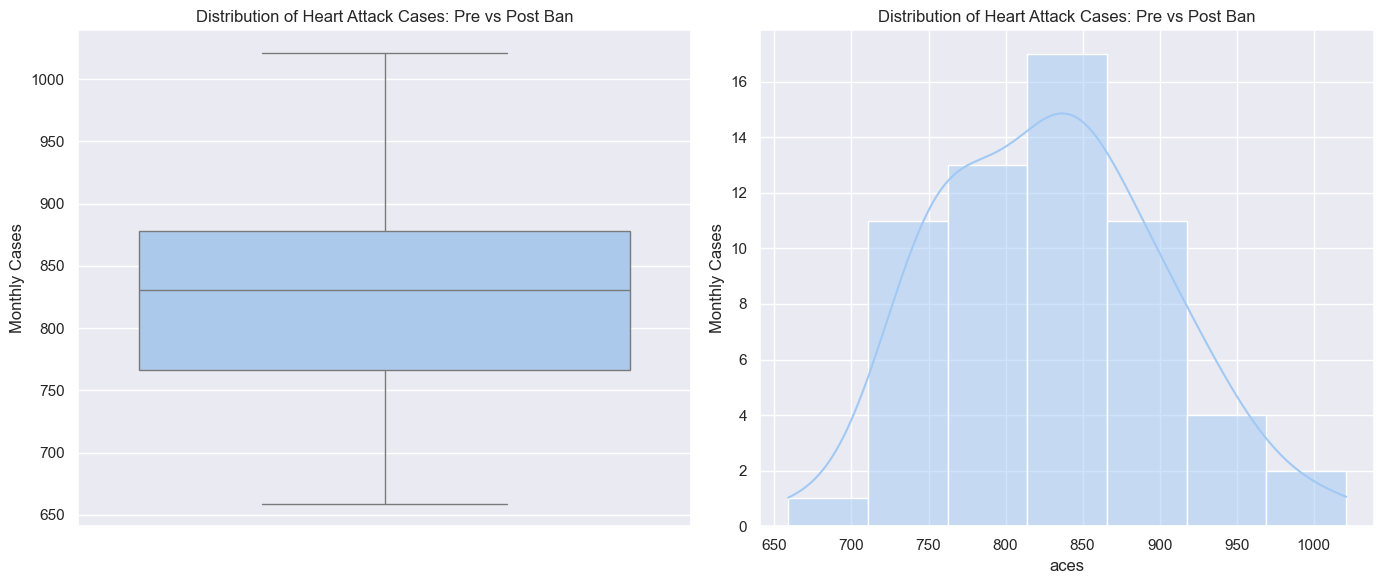

In [56]:
# visualizing ACE pre and post ban distributions
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.boxplot(data=df, y='aces')
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.tight_layout()

plt.subplot(1,2,2)
sns.histplot(data=df, x='aces', kde=True)
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.tight_layout()

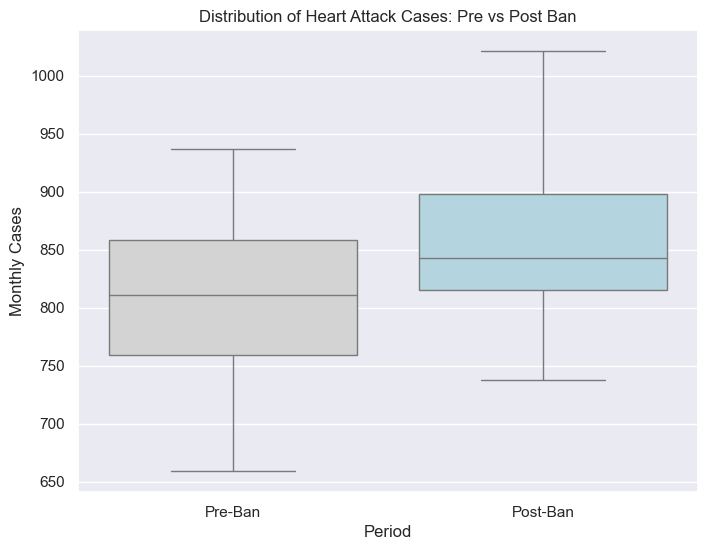

In [57]:
# visualizing ACE pre and post ban distributions
plt.figure(figsize=(8, 6))
df['Period'] = df['smokban'].map({0: 'Pre-Ban', 1: 'Post-Ban'})

sns.boxplot(data=df, x='Period', y='aces', palette=['lightgrey', 'lightblue'])
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.show()

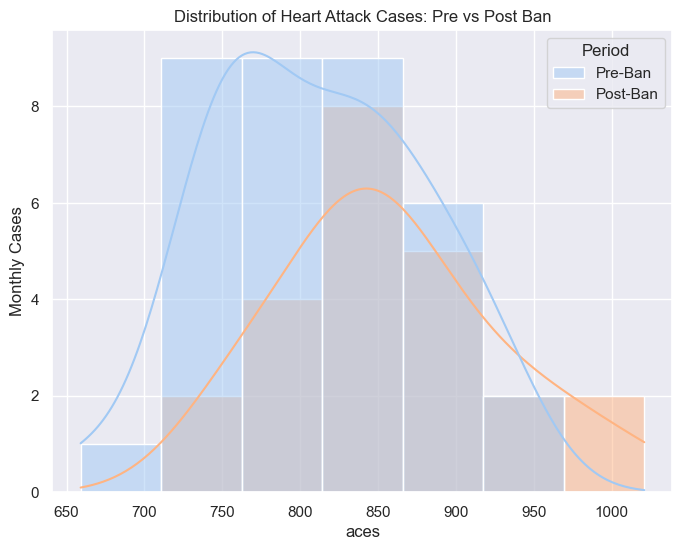

In [58]:
# visualizing ACE pre and post ban distributions
plt.figure(figsize=(8, 6))

sns.histplot(data=df, x='aces', hue="Period", kde=True)
plt.title('Distribution of Heart Attack Cases: Pre vs Post Ban')
plt.ylabel('Monthly Cases')
plt.show()

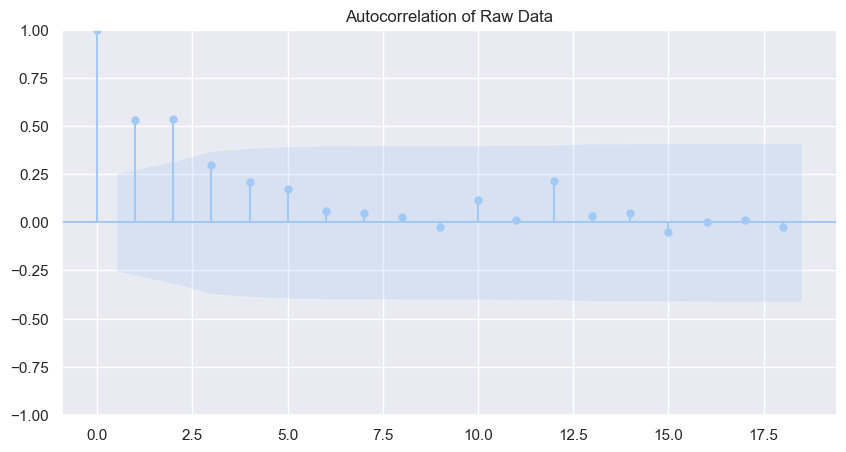

In [59]:
# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df['aces'], ax=ax)
plt.title('Autocorrelation of Raw Data')
plt.show()

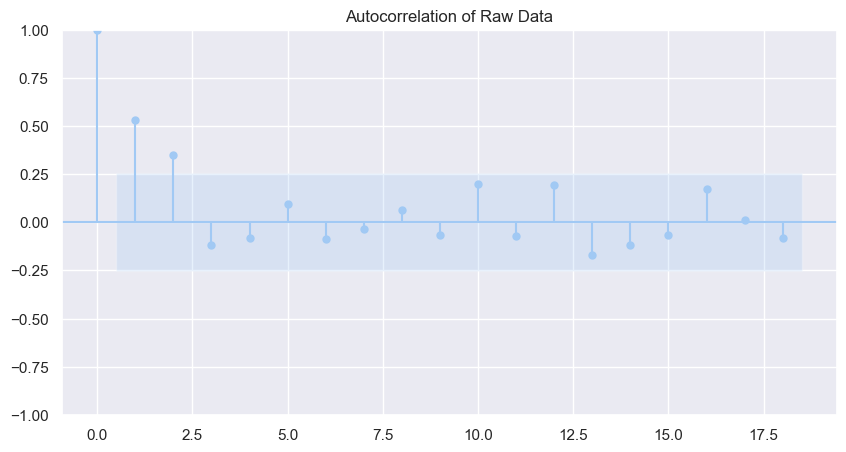

In [60]:
# Plot PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df['aces'], ax=ax)
plt.title('Autocorrelation of Raw Data')
plt.show()

In [61]:
# calculating time after ban column and converting month to categorial dtype
df['time_after_ban'] = (df['time'] - ban_start_time).clip(lower=0) * df['smokban']
df['month'] = df['month'].astype('category')

In [62]:
# handle Seasonality
seasonality = pd.get_dummies(df['month'], prefix='m', drop_first=True)
df_model = pd.concat([df, seasonality], axis=1)

# Prepare Design Matrices
X_columns = ['time', 'smokban', 'time_after_ban'] + list(seasonality.columns)

X_data = df_model[X_columns].astype(float).values 
y_data = df_model['aces'].values
log_pop = np.log(df_model['stdpop'].values)

In [63]:
# inspecting df tail once added time after ban column
df.tail()

,year,month,aces,time,smokban,pop,stdpop,Period,time_after_ban
54,2006,7,810,55,1,363832.6,391878.5,Post-Ban,18
55,2006,8,876,56,1,363832.6,388575.3,Post-Ban,19
56,2006,9,843,57,1,363832.6,392989.0,Post-Ban,20
57,2006,10,936,58,1,363832.6,390018.8,Post-Ban,21
58,2006,11,912,59,1,363832.6,390712.3,Post-Ban,22


In [ ]:
# creating the model
with pm.Model() as its_model:
    # MutableData (Data) allows us to swap this out for Counterfactuals
    X_shared = pm.Data('X_data', X_data)
    log_pop_shared = pm.Data('log_pop', log_pop)
    y_shared = pm.Data('y_data', y_data)
    
    # priors - intercept, Normal prior, wide
    beta0 = pm.Normal('beta0', mu=0, sigma=10)
    
    # Coefficients for all predictors (Time, Ban, Slope, Months)
    betas = pm.Normal('betas', mu=0, sigma=2, shape=len(X_columns))
    
    # pm.math.dot computes the matrix multiplication
    mu = pm.math.exp(beta0 + pm.math.dot(X_shared, betas) + log_pop_shared)
    
    # usinig Poisson for count data
    y_obs = pm.Poisson('y_obs', mu=mu, observed=y_shared)
    
    # Sample 2000 steps from the posterior distribution
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, betas]


In [ ]:
# create counterfactual data
df_cf = df.copy()
df_cf['smokban'] = 0
df_cf['time_after_ban'] = 0
X_cf = df_cf[X_columns].values

with its_model:
    # swap the data in the model container
    pm.set_data({'X_data': X_cf})
    
    # sample posterior Ppredictive samples
    post_pred = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

# extract the counterfactual predictions (samples x time_points)
y_cf_samples = post_pred.posterior_predictive['y_obs'].stack(sample=("chain", "draw")).values
y_cf_mean = y_cf_samples.mean(axis=1)
# calculate 94% High Density Interval (Credible Interval)
y_cf_hdi = az.hdi(post_pred.posterior_predictive)['y_obs']

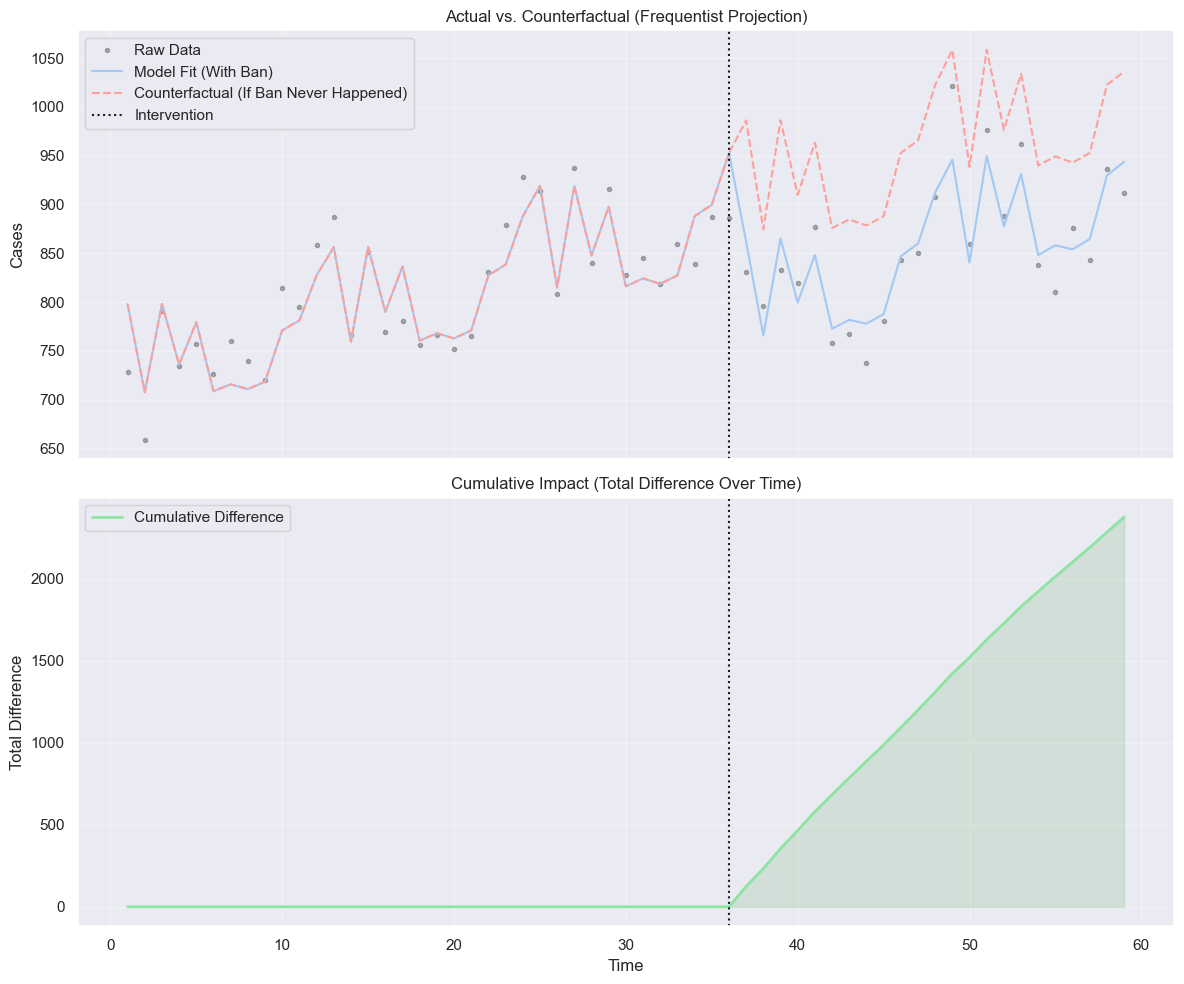

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

# 1. Plot Actual Data
ax.scatter(df['time'], df['aces'], color='k', s=20, alpha=0.5, label='Observed Data')

# 2. Plot Counterfactual (Mean + Uncertainty Band)
ax.plot(df['time'], y_cf_mean, color='C1', label='Counterfactual (No Ban)')
ax.fill_between(df['time'], 
                y_cf_hdi.sel(hdi="lower"), 
                y_cf_hdi.sel(hdi="higher"), 
                color='C1', alpha=0.2, label='94% Credible Interval')

# 3. Intervention Line
ax.axvline(x=ban_start, color='k', linestyle='--', label='Intervention')

ax.set_title("Bayesian ITS: Observed vs. Counterfactual (Poisson)", fontsize=14)
ax.legend()
plt.show()

# Calculate Cumulative Impact (Total prevented cases)
# Sum of (Counterfactual - Actual) for every posterior sample
post_ban_mask = df['time'] >= ban_start
total_prevented_samples = (y_cf_samples[post_ban_mask, :] - df.loc[post_ban_mask, 'aces'].values[:, None]).sum(axis=0)

print(f"Mean prevented cases: {total_prevented_samples.mean():.0f}")
print(f"94% Credible Interval: {az.hdi(total_prevented_samples, hdi_prob=0.94)}")